## Importar librerias y cargar datos

In [76]:
import pandas as pd 
import sqlalchemy
import missingno as msn 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np

df = pd.read_csv('../../Data/df.csv')
#DROP COLUMNS
df = df.drop(columns=['adjustSquareMeterPrice', 'automaticACMPrice', 'created_at', 'terraceValue',
                       'utilityRoomValue', 'preofferAcmHigherValue','preofferAcmLowerValue','buildingFloors','estateFloors',
                       'rentValue','garageType','terraceArea','zone','garageValue', 'type'])
def preprocesamiento(df):
    #Drop rows with null values in Y variable
    df = df[df.finalACMPrice.notna()]
    #Calculate Antiguedad of a property in years
    df['Antiguedad'] = date.today().year - df['year']
    df['Antiguedad'] = df['Antiguedad'].astype(int)
    df = df.drop(columns=['id', 'purchaseCaseId', 'year'])
    #delete rows with null values in stratum variables
    df = df[df.stratum.notna()]
    #Turn floor to integer
    df = df[df.floor.notna()]
    df['floor'] = df['floor'].astype(int)
    #df = df[df.stratum.notna()]
    # Convert hasElevator to categorical
    df['hasElevator'] = df['hasElevator'].astype('category')
    return df
df = preprocesamiento(df)

C:\Users\User\AppData\Local\Temp\ipykernel_21400\1282984739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Antiguedad'] = date.today().year - df['year']
C:\Users\User\AppData\Local\Temp\ipykernel_21400\1282984739.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Antiguedad'] = df['Antiguedad'].astype(int)


### Ejemplo del dataset que se usara en los modelos

In [77]:
df.sample(10)

,finalACMPrice,area,bathrooms,hasElevator,floor,stratum,garages,latitude,longitude,Antiguedad
2962,1.459540e+08,46.0,1,0.0,1,3.0,0,4.755332,-74.075926,7
12804,2.506072e+08,68.0,2,1.0,11,3.0,1,4.654565,-74.140140,3
3297,1.923471e+08,63.0,2,1.0,2,3.0,1,6.151888,-75.636807,10
5262,9.885759e+07,28.0,1,0.0,2,3.0,0,4.580725,-74.089536,30
14747,4.840844e+08,85.0,2,1.0,8,4.0,1,4.738774,-74.057043,11
3991,1.261347e+08,44.0,1,1.0,3,2.0,0,4.624082,-74.179306,7
1308,1.365294e+08,54.0,1,0.0,2,3.0,0,4.762518,-74.025493,13
13233,2.302877e+08,60.0,1,0.0,3,3.0,1,6.326357,-75.564383,4
12253,1.899758e+08,60.0,2,1.0,21,3.0,1,6.324379,-75.547379,2
15728,2.129822e+08,68.0,2,0.0,3,3.0,1,6.340314,-75.549043,8


### Definir variable para aprendizaje supervisado y matriz X para no supervisado

In [78]:
X = df.drop(columns=['finalACMPrice'])
y = df['finalACMPrice']

Eliminamos la variable finalACMPrice de la matriz X sobre la cual aplicaremos la cauterización porque esta será utilizada para entrenar un modelo supervisado de regresión. 

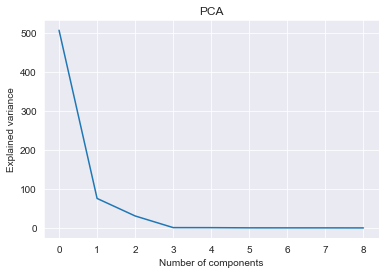

In [79]:
from sklearn.decomposition import PCA
#PCA METHOD
pca = PCA(n_components=9)
pca.fit(X)

plt.plot(pca.explained_variance_)
plt.title('PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

Podemos ver que el 'codo' de la gráfica se crea en el componente principal número 3. Esto quiere decir que los primeros 3 componentes explican la mayor parte de la información en nuestra matriz. Por lo tanto, procedemos con 3 componentes. 

In [80]:
#PCA METHOD
pca = PCA(n_components=3)
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X))

In [81]:
#Show components weights
pd.DataFrame(pca.components_, columns=X.columns, index = ['PC-1','PC-2','PC-3'])

,area,bathrooms,hasElevator,floor,stratum,garages,latitude,longitude,Antiguedad
PC-1,0.997073,0.019850,0.005413,0.016295,0.022194,0.019451,0.005561,-0.004293,0.065090
PC-2,0.047563,0.006409,0.023682,0.499121,-0.003995,0.005670,0.036909,-0.035860,-0.863318
PC-3,-0.047413,0.002026,0.010776,0.864096,0.011244,0.003963,0.027478,-0.024893,0.499452


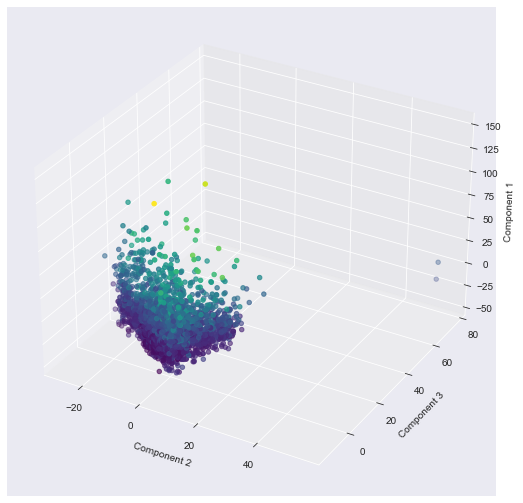

In [66]:
plt.figure(figsize=(10,9))
axes = plt.axes(projection='3d')

axes.scatter3D(X_pca[1], X_pca[2],X_pca[0], c=y, cmap='viridis')

axes.set_xlabel('Component 2')
axes.set_ylabel('Component 3')
axes.set_zlabel('Component 1')
plt.show()


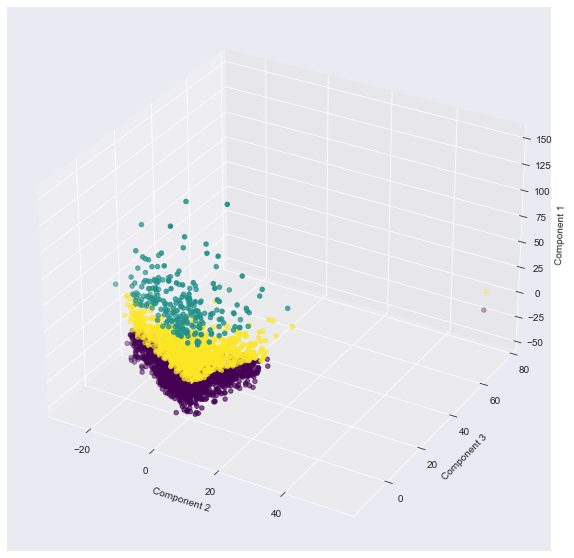

In [67]:
#apply kmeans to X_train
from sklearn.cluster import KMeans

#kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

#predicciones
segmentacion_kmeans = kmeans.predict(X_pca)

plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')

axes.scatter3D(X_pca[1], X_pca[2],X_pca[0], c=segmentacion_kmeans, cmap='viridis')

axes.set_xlabel('Component 2')
axes.set_ylabel('Component 3')
axes.set_zlabel('Component 1')
plt.show()


### Concatenar la segmentacion con el dataset original X


In [68]:
X['Segmentacion'] = segmentacion_kmeans
X.sample(10)

,area,bathrooms,hasElevator,floor,stratum,garages,latitude,longitude,Antiguedad,Segmentacion
16882,38.0,1,1.0,6,2.0,0,4.596850,-74.160117,1,0
3079,42.0,2,1.0,18,3.0,0,6.183180,-75.650718,5,0
6841,55.0,1,0.0,3,2.0,1,4.580778,-74.129557,3,0
15627,117.0,4,1.0,22,4.0,2,6.182080,-75.576417,15,1
5820,54.0,1,1.0,4,3.0,1,4.702638,-74.091484,11,0
2899,53.0,2,1.0,13,4.0,0,6.252881,-75.560880,18,0
4258,54.0,2,0.0,4,3.0,1,4.696997,-74.111677,15,0
13889,65.0,2,1.0,3,3.0,1,6.173912,-75.576907,7,2
7357,64.0,2,0.0,2,2.0,1,4.584949,-74.203806,0,2
4181,55.0,2,1.0,9,3.0,1,6.341125,-75.571046,1,0


### Particionamiento de los datos en train y test set

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                 test_size=0.2,
                                                    random_state=42)

In [70]:
#Train LightGBMRegresor model
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

#Fit model
lgbm = LGBMRegressor(n_estimators=258, learning_rate=0.01, random_state=42)
lgbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, n_estimators=258, random_state=42)

In [71]:
#Predict
y_pred = lgbm.predict(X_test)
#Evaluate
mae_kmeans = mean_absolute_error(y_test, y_pred)


In [72]:
#Print results in currency format
print('MAE Kmeans: ${:,.2f}'.format(mae_kmeans))

MAE Kmeans: $28,247,010.79


# Proceso de segmentación con DBSCAN